In [ ]:
import sys
sys.path.append("../")

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import pandas as pd
from tqdm import tqdm

from src.training.utils import load_model_from_checkpoint, inference_on_image, calculate_inference_metrics
from src.data.data_module import SegmentationDataModule
from src.utils import deaugment_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model_checkpoints = {
    'UNet': Path('checkpoints/unet_best.ckpt'),
    'FPN': Path('checkpoints/fpn_best.ckpt'),
    'DinoV2': Path('checkpoints/dino_best.ckpt'),
}

test_images_dir = Path('/workspace/data/new_processed/tier_1/images')
test_masks_dir = Path('/workspace/data/new_processed/tier_1/masks')

In [ ]:
models = {}

for model_name, checkpoint_path in model_checkpoints.items():
    if checkpoint_path.exists():
        model = load_model_from_checkpoint(
            checkpoint_path=checkpoint_path,
            device=DEVICE
        )
        models[model_name] = model


In [ ]:
def visualize_predictions(image, gt_mask, predictions, model_names, figsize=(20, 5)):
    n_models = len(predictions)
    fig, axes = plt.subplots(1, n_models + 2, figsize=figsize)
    
    axes[0].imshow(image)
    axes[0].set_title('Input Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(gt_mask, cmap='gray')
    axes[1].set_title('Ground Truth', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    for idx, (pred_mask, model_name) in enumerate(zip(predictions, model_names)):
        axes[idx + 2].imshow(pred_mask, cmap='gray')
        axes[idx + 2].set_title(f'{model_name}', fontsize=14, fontweight='bold')
        axes[idx + 2].axis('off')
    
    plt.tight_layout()
    return fig

def visualize_overlay(image, gt_mask, predictions, model_names, figsize=(20, 5), alpha=0.4):
    n_models = len(predictions)
    fig, axes = plt.subplots(1, n_models + 2, figsize=figsize)
    
    axes[0].imshow(image)
    axes[0].set_title('Input Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(image)
    axes[1].imshow(gt_mask, cmap='Reds', alpha=alpha)
    axes[1].set_title('GT Overlay', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    for idx, (pred_mask, model_name) in enumerate(zip(predictions, model_names)):
        axes[idx + 2].imshow(image)
        axes[idx + 2].imshow(pred_mask, cmap='Blues', alpha=alpha)
        axes[idx + 2].set_title(f'{model_name} Overlay', fontsize=14, fontweight='bold')
        axes[idx + 2].axis('off')
    
    plt.tight_layout()
    return fig


In [ ]:
model
test_images_dir

In [ ]:
image_files = sorted(test_images_dir.glob('*.png'))[:10]


results = []

for img_path in tqdm(image_files):
    mask_path = test_masks_dir / img_path.name
    
    if not mask_path.exists():
        print(f"Warning: Mask not found for {img_path.name}")
        continue
    
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    gt_mask = (gt_mask > 0).astype(np.float32)
    
    result = {
        'image_name': img_path.name,
        'image': image,
        'gt_mask': gt_mask,
        'predictions': {},
        'metrics': {}
    }
    
    for model_name, model in models.items():
        pred_mask = inference_on_image(
            model=model,
            image=image,
            device=DEVICE,
            threshold=0.5,
            return_numpy=True
        )
        
        metrics = calculate_inference_metrics(pred_mask, gt_mask)
        
        result['predictions'][model_name] = pred_mask
        result['metrics'][model_name] = metrics
    
    results.append(result)



In [ ]:
for idx, result in enumerate(results[:5]):
    print(f"\n{'='*80}")
    print(f"Image {idx+1}: {result['image_name']}")
    print(f"{'='*80}")
    
    model_names = list(result['predictions'].keys())
    predictions = [result['predictions'][name] for name in model_names]
    
    print("\nMetrics:")
    for model_name in model_names:
        metrics = result['metrics'][model_name]
        print(f"  {model_name:15s} - IoU: {metrics['iou']:.4f}, Dice: {metrics['dice']:.4f}, F1: {metrics['f1']:.4f}")
    
    visualize_predictions(
        result['image'],
        result['gt_mask'],
        predictions,
        model_names,
        figsize=(20, 5)
    )
    plt.show()
    
    visualize_overlay(
        result['image'],
        result['gt_mask'],
        predictions,
        model_names,
        figsize=(20, 5),
        alpha=0.4
    )
    plt.show()

In [ ]:
model_names = list(models.keys())
results = {model_name: {} for model_name in model_names}

for model_name in model_names:
    all_metrics = [result['metrics'][model_name] for result in results]
    
    for metric_name in ['iou', 'dice', 'precision', 'recall', 'f1']:
        values = [m[metric_name] for m in all_metrics]
        results[model_name][metric_name] = np.mean(values)

metrics_df = pd.DataFrame(results).T
metrics_df.columns = [col.upper() for col in metrics_df.columns]

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

metrics_to_plot = ['iou', 'dice', 'precision', 'recall']
image_indices = range(len(results))

for idx, metric_name in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    for model_name in model_names:
        values = [result['metrics'][model_name][metric_name] for result in results]
        ax.plot(image_indices, values, marker='o', label=model_name, linewidth=2)
    
    ax.set_xlabel('Image Index', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_name.upper(), fontsize=12, fontweight='bold')
    ax.set_title(f'{metric_name.upper()} per Image', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# df =pd.DataFrame({"iou": results})
# df.to_csv("dinov3/iou_log.csv")

In [276]:
start, end, n

(51.7, 73.6, 100)

In [ ]:
df_general = {}
for model in ["unet", "fpn", "dinov3"]:
    df = pd.read_csv(f"{model}/iou_log.csv")
    df_general[model] = df['iou'].tolist()
    

In [304]:
df_general = pd.DataFrame(df_general)

In [305]:
table = pd.DataFrame({"IoU": df_general.max()}).T
table

,unet,fpn,dinov3
IoU,65.232252,67.527118,73.860462


<Axes: >

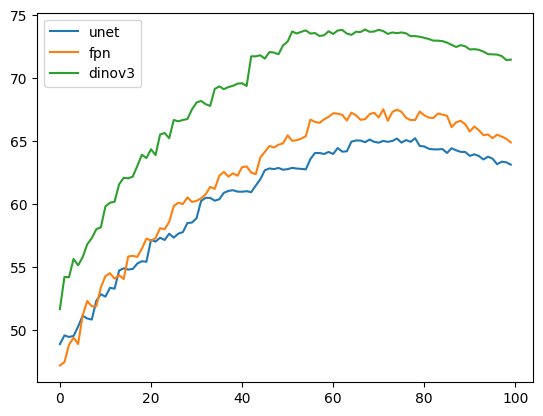

In [279]:
df_general.plot()

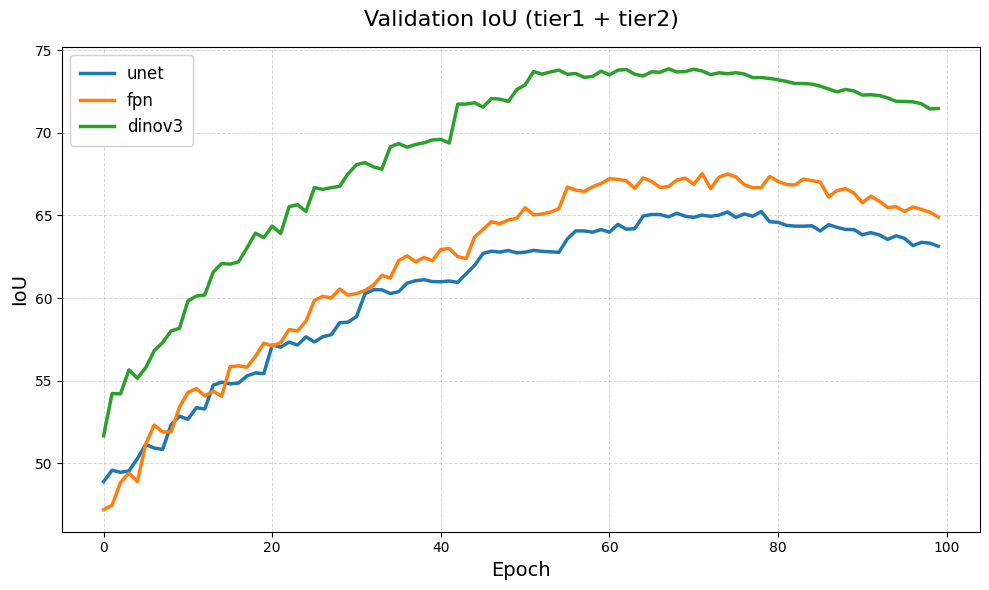

In [281]:
import matplotlib.pyplot as plt

def pretty_iou_plot(df, title="Validation IoU Over Epochs"):
    plt.figure(figsize=(10, 6))

    # Main plot — smooth, thicker lines
    for col in df.columns:
        plt.plot(
            df.index,
            df[col],
            label=col,
            linewidth=2.5,
        )

    # Title + labels
    plt.title(title, fontsize=16, pad=15)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("IoU", fontsize=14)

    # Grid
    plt.grid(
        True,
        linestyle="--",
        linewidth=0.7,
        color="gray",
        alpha=0.3
    )

    # Legend
    plt.legend(
        fontsize=12,
        fancybox=True,
        framealpha=0.9,
        shadow=False,
        borderpad=0.6
    )

    # Tighter layout
    plt.tight_layout()
    plt.show()

# Usage:
pretty_iou_plot(df_general, title= "Validation IoU (tier1 + tier2)")


In [188]:
import cv2
import numpy as np

def draw_mask_contours(image, mask, color=(0, 255, 0), thickness=2):
    """
    Draws contour lines of a binary mask on top of an RGB image.

    Parameters
    ----------
    image : np.ndarray
        Input RGB image of shape (H, W, 3) in uint8.
    mask : np.ndarray
        Ground-truth mask of shape (H, W), binary (0/1 or 0/255).
    color : tuple
        BGR color for contour (OpenCV format), e.g. (0,255,0) for green.
    thickness : int
        Line thickness.

    Returns
    -------
    np.ndarray
        Image with drawn contours (RGB).
    """

    # ensure mask is binary (0/255)
    mask_bin = (mask > 0).astype(np.uint8) * 255

    # find mask contours
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # make a copy to draw on
    overlay = image.copy()

    # draw contours
    cv2.drawContours(overlay, contours, -1, color, thickness)

    return overlay


In [367]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

data = Path("/workspace/data/new_processed/tier_1/dar")

# idx = 1215 #tier2
# idx = 15624 #tier2

idx = 3025
# idx = 7050

example_image_path = list(data.rglob("*/x_*.png"))[idx]
example_gt_path = str(example_image_path).replace("x_", "y_")

image = plt.imread(example_image_path)
mask = cv2.imread(example_gt_path, cv2.IMREAD_ANYCOLOR)

vis = draw_mask_contours(image, mask)

In [ ]:
# import sys
# sys.path.append("../")
# import matplotlib.pyplot as plt
# from src.data.data_module import SegmentationDataModule
# import torch
# import numpy as np
# from src.training.train_model import SegmentationModel
# from src.training.models import DinoSegmentor
# import lightning as L
# from src.utils import deaugment_image
# from src.callbacks import SaveStateDictCallback
# from src.training.models.fpn import FPN

# ENCODER = 'se_resnext50_32x4d'
# ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['roof']
# ACTIVATION = None # could be None for logits or 'softmax2d' for multicalss segmentation
# DEVICE = 'cuda'

# # create segmentation model with pretrained encoder
# model = FPN(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=None,
# ).to(DEVICE)

# state_dict = torch.load("fpn_nia/fpn_epoch_001.pth")

# new_state_dict = {}
# for k, v in state_dict.items():
#     if "model.model." in k:
#         new_state_dict[k.replace("model.model.", "")] = v
    
# model.load_state_dict(new_state_dict if new_state_dict else state_dict)



<All keys matched successfully>

In [369]:
import albumentations as A
train_augs = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),

    # # Normalize last (before converting to tensor)
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),

    A.ToTensorV2()
])

with torch.inference_mode():
    with torch.no_grad():
        x = torch.tensor(train_augs(image=image)['image'])[None].cuda()
        result = (model(x).cpu().sigmoid().numpy())[0][0] > 0.5


/tmp/ipykernel_39974/2178118546.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train_augs(image=image)['image'])[None].cuda()


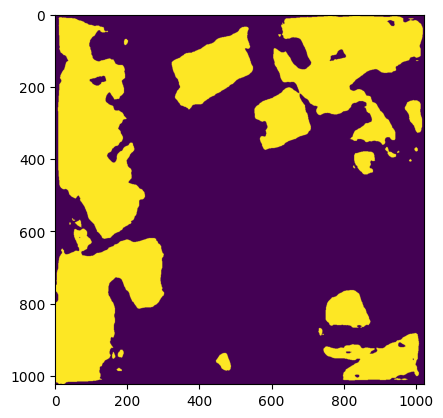

In [370]:
import cv2
result = (result * 255).astype(np.uint8)
vis = draw_mask_contours(vis, result, color=(255, 0, 0))
plt.imshow(result)

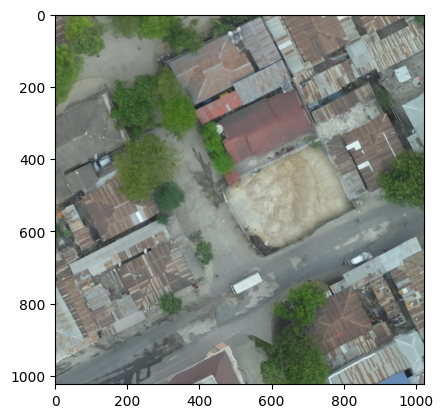

In [371]:
plt.imshow(image)